In [117]:
# Code from https://towardsdatascience.com/custom-dataset-in-pytorch-part-1-images-2df3152895

import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm



In [243]:
#######################################################
#               Define Transforms
#######################################################

#To define an augmentation pipeline, you need to create an instance of the Compose class.
#As an argument to the Compose class, you need to pass a list of augmentations you want to apply. 
#A call to Compose will return a transform function that will perform image augmentation.
#(https://albumentations.ai/docs/getting_started/image_augmentation/)

train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=256),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256, width=256),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        #A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.5), std=(0.5)),
        #A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=256),
        A.CenterCrop(height=256, width=256),
        A.Normalize(mean=(0.5), std=(0.5)),
        ToTensorV2(),
    ]
)

In [244]:
train_data_path = 'train'
test_data_path = 'test'

train_image_paths = []
classes = []

for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('\\')[-1])
    train_image_paths.append(glob.glob(data_path + '/*'))

train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

#2.
# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))
random.shuffle(test_image_paths)

print("Train size: {}\nTest size: {}".format(len(train_image_paths), len(test_image_paths)))


train_image_path example:  train\curr_src\125.png
class example:  ac_src
Train size: 2003
Test size: 495


In [245]:
#######################################################
#               Define Dataset Class
#######################################################

class ComponentDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        label = image_filepath.split('\\')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label
    
#######################################################
#                  Create Dataset
#######################################################

train_dataset = ComponentDataset(train_image_paths,train_transforms)
test_dataset = ComponentDataset(test_image_paths,test_transforms)

In [246]:
#######################################################
#      Create dictionary for class indexes
#######################################################

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

print(class_to_idx)
print(train_dataset[0][0][0].shape)

{'ac_src': 0, 'battery': 1, 'cap': 2, 'curr_src': 3, 'diode': 4, 'inductor': 5, 'resistor': 6, 'swi_ideal': 7, 'swi_real': 8, 'volt_src': 9}
torch.Size([256, 256])


In [247]:
print('The shape of tensor for 50th image in train dataset: ',train_dataset[49][0].shape)
print('The label for 50th image in train dataset: ',train_dataset[49][1])

The shape of tensor for 50th image in train dataset:  torch.Size([1, 256, 256])
The label for 50th image in train dataset:  1


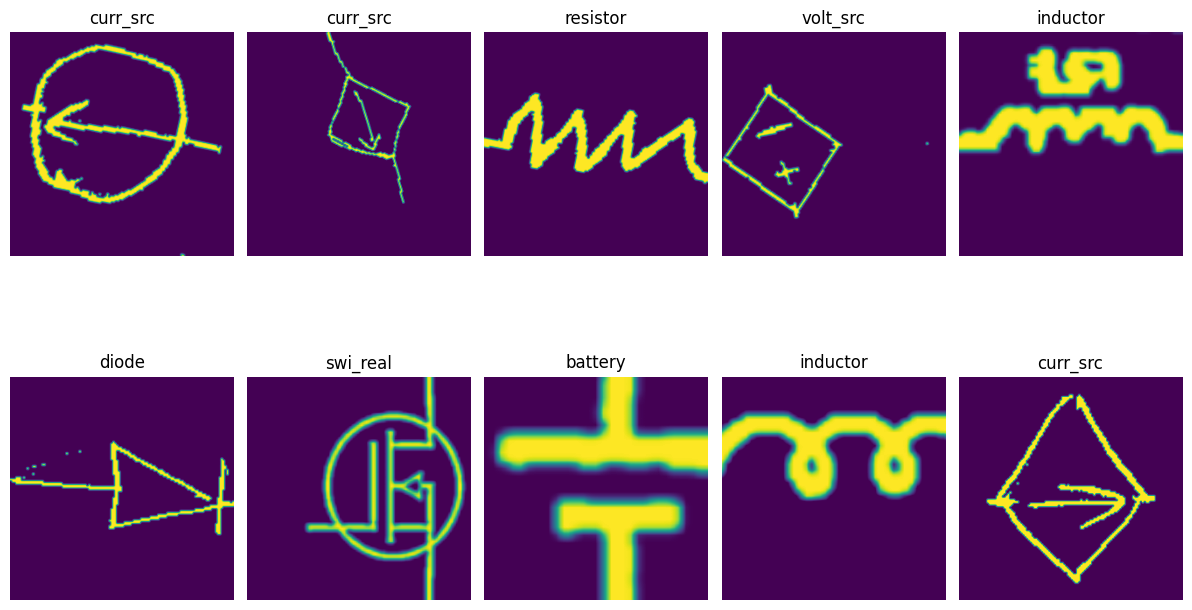

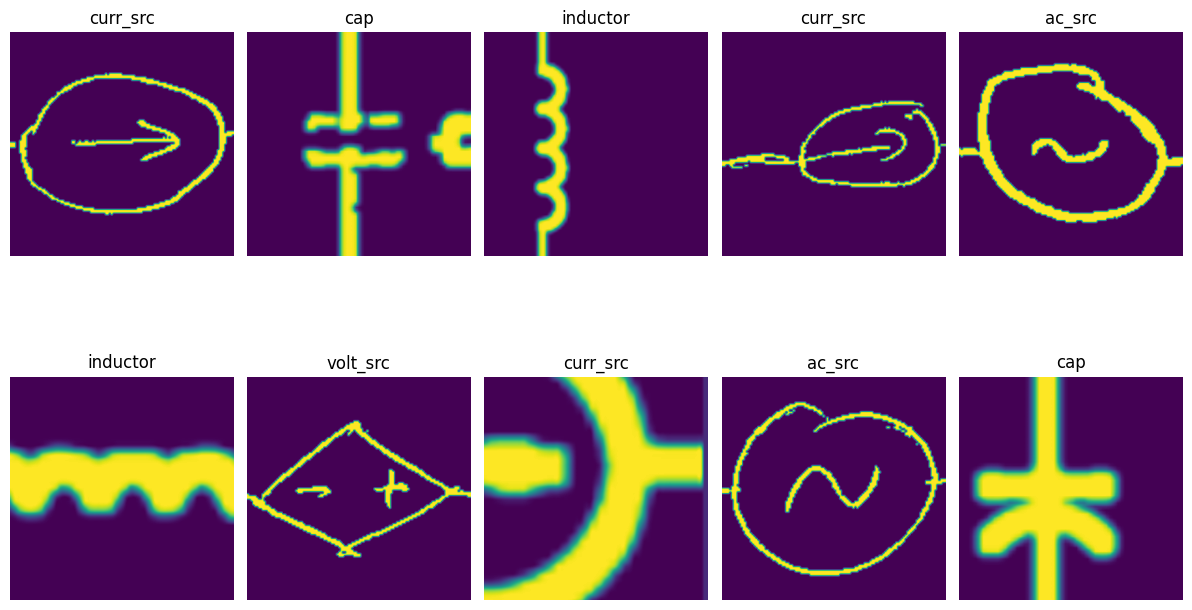

In [248]:
import matplotlib.pyplot as plt
%matplotlib inline

#######################################################
#                  Visualize Dataset
#         Images are plotted after augmentation
#######################################################

def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False, train=True):
    
    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            if train:
                idx = np.random.randint(1,len(train_image_paths))
            else:
                idx = np.random.randint(1,len(test_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)
visualize_augmentations(test_dataset,np.random.randint(1,len(test_image_paths)), random_img = True, train=False)


In [249]:

#######################################################
#                  Define Dataloaders
#######################################################

trainloader = DataLoader(
    train_dataset, batch_size=4, shuffle=True
)

testloader = DataLoader(
    test_dataset, batch_size=4, shuffle=True
)

In [250]:
''' Models a simple Convolutional Neural Network'''
class Net(nn.Module):
    def __init__(self):
        ''' initialize the network '''
        super(Net, self).__init__()
    	# 3 input image channel, 6 output channels, 
    	# 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
    	# Max pooling over a (2, 2) window
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1 = nn.Linear(59536, 120)# 5x5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    ''' the forward propagation algorithm '''
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #x = x.view(-1, 16 * 5 * 5)
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [251]:
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [252]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

net.cuda()

start.record()

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.cuda())
        loss = criterion(outputs.cuda(), labels.cuda())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

# whatever you are timing goes here
end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print('Finished Training')
print(start.elapsed_time(end))  # milliseconds

Finished Training
19633.6796875


GroundTruth:  inductor inductor curr_src curr_src


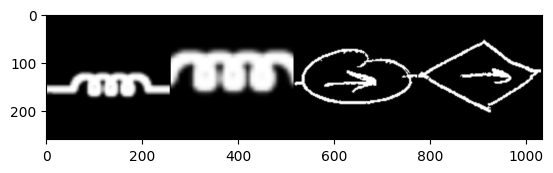

In [253]:
import torchvision
dataiter = iter(testloader)
images, labels = next(dataiter)

images -= images.min()
images /= images.max()

plt.imshow(torchvision.utils.make_grid(images, nrow=5).permute(1, 2, 0))
print('GroundTruth: ', ' '.join('%s' % classes[labels[j]] for j in range(4)))

In [254]:
# # save
# PATH = './powercmp.pth'
# torch.save(net.state_dict(), PATH)
# # reload
# net = Net()
# net.load_state_dict(torch.load(PATH))

In [255]:
outputs = net(images.cuda())

_, predicted = torch.max(outputs.cuda(), 1)

print('Predicted: ', ' '.join('%s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  inductor diode curr_src volt_src


In [256]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 34 %
